In this notebook, we will explore this phenomenon using age distribution data to see if we can reproduce a difference in average age at death purely from the changing rates of left-handedness over time, refuting the claim of early death for left-handers. This notebook uses pandas and Bayesian statistics to analyze the probability of being a certain age at death given that you are reported as left-handed or right-handed.

   Age       Male     Female
0   10  12.717558  12.198041
1   11  15.318830  11.144804
2   12  14.808281  11.549240
3   13  13.793744  11.276442
4   14  15.156304  11.572906


Text(0, 0.5, 'Percentage of people who are left-handed')

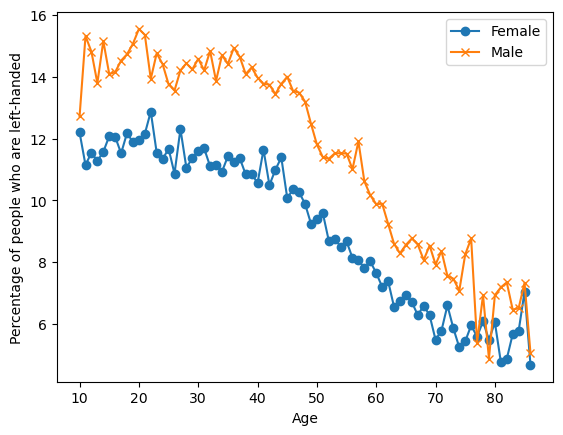

In [ ]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
# load the data
data_url_1 = "https://gist.githubusercontent.com/mbonsma/8da0990b71ba9a09f7de395574e54df1/raw/aec88b30af87fad8d45da7e774223f91dad09e88/lh_data.csv"
lefthanded_data = pd.read_csv(data_url_1)
print(lefthanded_data.head())

# plot male and female left-handedness rates vs. age
%matplotlib inline
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(lefthanded_data["Age"], lefthanded_data["Female"], label="Female", marker = 'o') # plot "Female" vs. "Age"
ax.plot(lefthanded_data["Age"], lefthanded_data["Male"], label="Male", marker = 'x') # plot "Male" vs. "Age"
ax.legend() # add a legend
ax.set_xlabel("Age")
ax.set_ylabel("Percentage of people who are left-handed")

 Rates of left-handedness over time

 Let's convert this data into a plot of the rates of left-handedness as a function of the year of birth, and average over male and female to get a single rate for both sexes.

 Since the study was done in 1986, the data after this conversion will be the percentage of people alive in 1986 who are left-handed as a function of the year they were born.




Text(0, 0.5, 'Percentage left-handed')

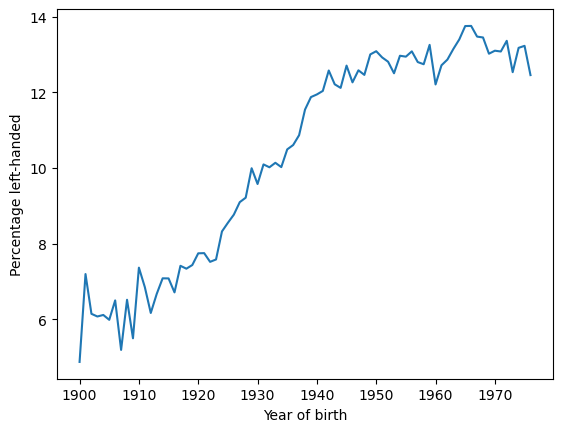

In [ ]:
# create a new column for birth year of each age
lefthanded_data['Birth_year'] = 1986 - lefthanded_data["Age"]

# create a new column for the average of male and female
lefthanded_data['Mean_lh'] = lefthanded_data[["Female","Male"]].mean(axis =1)

# create a plot of the 'Mean_lh' column vs. 'Birth_year'
fig, ax = plt.subplots()
ax.plot("Birth_year", "Mean_lh", data=lefthanded_data) # plot 'Mean_lh' vs. 'Birth_year'
ax.set_xlabel("Year of birth") # set the x label for the plot
ax.set_ylabel("Percentage left-handed") # set the y label for the plot

 The probability of dying at a certain age given that you're left-handed is not equal to the probability of being left-handed given that you died at a certain age. This inequality is why we need Bayes' theorem, a statement about conditional probability which allows us to update our beliefs after seeing evidence.

 We want to calculate the probability of dying at age A given that you're left-handed. Let's write this in shorthand as P(A | LH). We also want the same quantity for right-handers: P(A | RH).

In [ ]:
# import library
import numpy as np

# create a function for P(LH | A)
def P_lh_given_A(ages_of_death, study_year = 1990):
    """ P(Left-handed | ages of death), calculated based on the reported rates of left-handedness.
    Inputs: numpy array of ages of death, study_year
    Returns: probability of left-handedness given that subjects died in `study_year` at ages `ages_of_death` """

    # Use the mean of the 10 last and 10 first points for left-handedness rates before and after the start
    early_1900s_rate = lefthanded_data['Mean_lh'][-10:].mean()
    late_1900s_rate = lefthanded_data['Mean_lh'][:10].mean()
    middle_rates = lefthanded_data.loc[lefthanded_data['Birth_year'].isin(study_year - ages_of_death)]['Mean_lh']
    youngest_age = study_year - 1986 + 10 # the youngest age is 10
    oldest_age = study_year - 1986 + 86 # the oldest age is 86

    P_return = np.zeros(ages_of_death.shape) # create an empty array to store the results
    # extract rate of left-handedness for people of ages 'ages_of_death'
    P_return[ages_of_death > oldest_age] = early_1900s_rate / 100
    P_return[ages_of_death < youngest_age] = late_1900s_rate / 100
    P_return[np.logical_and((ages_of_death <= oldest_age), (ages_of_death >= youngest_age))] = middle_rates / 100

    return P_return

 In this block, we'll load in the death distribution data and plot it. The first column is the age, and the other columns are the number of people who died at that age.

Text(0, 0.5, 'Number of people who died')

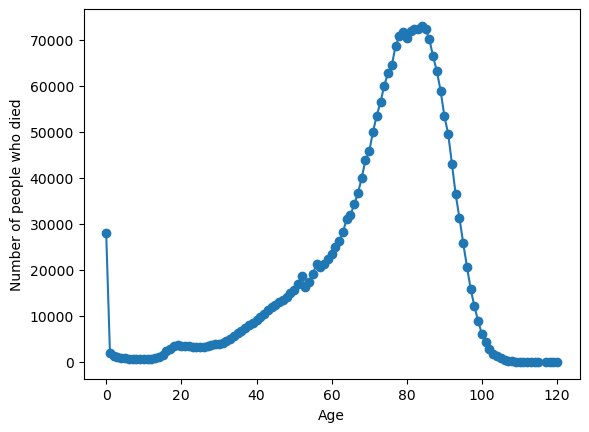

In [ ]:
# Death distribution data for the United States in 1999
data_url_2 = "https://gist.githubusercontent.com/mbonsma/2f4076aab6820ca1807f4e29f75f18ec/raw/62f3ec07514c7e31f5979beeca86f19991540796/cdc_vs00199_table310.tsv"

# load death distribution data
death_distribution_data = pd.read_csv(data_url_2,sep='\t', skiprows=[1])

# drop NaN values from the `Both Sexes` column
death_distribution_data = death_distribution_data.dropna(subset=["Both Sexes"])

# plot number of people who died as a function of age
fig, ax = plt.subplots()
ax.plot("Age", "Both Sexes", data = death_distribution_data, marker='o') # plot 'Both Sexes' vs. 'Age'
ax.set_xlabel("Age")
ax.set_ylabel("Number of people who died")

In the previous code block we loaded data to give us P(A), and now we need P(LH). P(LH) is the probability that a person who died in our particular study year is left-handed, assuming we know nothing else about them. This is the average left-handedness in the population of deceased people, and we can calculate it by summing up all of the left-handedness probabilities for each age, weighted with the number of deceased people at each age, then divided by the total number of deceased people to get a probability.

In [ ]:
def P_lh(death_distribution_data, study_year = 1990): # sum over P_lh for each age group
    """ Overall probability of being left-handed if you died in the study year
    Input: dataframe of death distribution data, study year
    Output: P(LH), a single floating point number """
    p_list = death_distribution_data['Both Sexes']*P_lh_given_A(death_distribution_data['Age'],study_year) # multiply number of dead people by P_lh_given_A
    p = np.sum(p_list) # calculate the sum of p_list
    return p/np.sum(death_distribution_data['Both Sexes']) # normalize to total number of people (sum of death_distribution_data['Both Sexes'])

print(P_lh(death_distribution_data))

0.07766387615350638


 Now we have the means of calculating all three quantities we need: P(A), P(LH), and P(LH | A). We can combine all three using Bayes' rule to get P(A | LH), the probability of being age A at death (in the study year) given that you're left-handed. To make this answer meaningful, though, we also want to compare it to P(A | RH), the probability of being age A at death given that you're right-handed.

In [ ]:
def P_A_given_lh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're left-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_left = P_lh(death_distribution_data, study_year) # use P_lh function to get probability of left-handedness overall
    P_lh_A = P_lh_given_A(ages_of_death, study_year) # use P_lh_given_A to get probability of left-handedness for a certain age
    return P_lh_A*P_A/P_left

# And now for right-handers.

In [ ]:
def P_A_given_rh(ages_of_death, death_distribution_data, study_year = 1990):
    """ The overall probability of being a particular `age_of_death` given that you're right-handed """
    P_A = death_distribution_data['Both Sexes'][ages_of_death] / np.sum(death_distribution_data['Both Sexes'])
    P_right = 1- P_lh(death_distribution_data, study_year) # either you're left-handed or right-handed, so these sum to 1
    P_rh_A = 1-P_lh_given_A(ages_of_death, study_year) # these also sum to 1
    return P_rh_A*P_A/P_right

Now that we have functions to calculate the probability of being age A at death given that you're left-handed or right-handed, let's plot these probabilities for a range of ages of death from 6 to 120.

Notice that the left-handed distribution has a bump below age 70: of the pool of deceased people, left-handed people are more likely to be younger.

Text(0, 0.5, 'Probability of being age A at death')

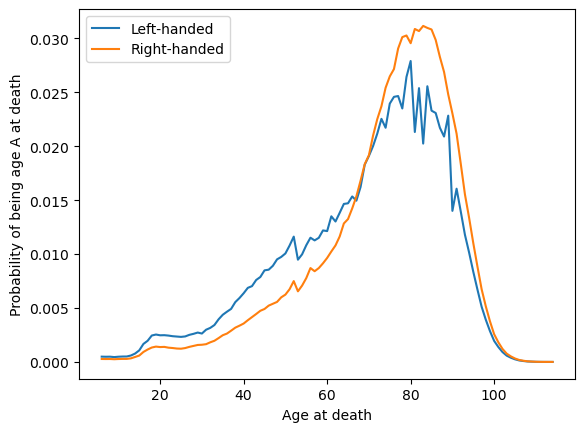

In [ ]:
ages = np.arange(6, 115, 1) # make a list of ages of death to plot

# calculate the probability of being left- or right-handed for each
left_handed_probability = P_A_given_lh(ages, death_distribution_data)
right_handed_probability = P_A_given_rh(ages, death_distribution_data)

# create a plot of the two probabilities vs. age
fig, ax = plt.subplots() # create figure and axis objects
ax.plot(ages, left_handed_probability, label = "Left-handed")
ax.plot(ages, right_handed_probability, label = "Right-handed")
ax.legend() # add a legend
ax.set_xlabel("Age at death")
ax.set_ylabel(r"Probability of being age A at death")

Finally, let's compare our results with the original study that found that left-handed people were nine years younger at death on average. We can do this by calculating the mean of these probability distributions in the same way we calculated P(LH) earlier, weighting the probability distribution by age and summing over the result.



In [ ]:
# calculate average ages for left-handed and right-handed groups
# use np.array so that two arrays can be multiplied
average_lh_age =  np.nansum(ages*np.array(left_handed_probability))
average_rh_age =  np.nansum(ages*np.array(right_handed_probability))

# print the average ages for each group
print(round(average_lh_age,1))
print(round(average_rh_age,1))

print("The difference in average ages is " + str(round(average_rh_age - average_lh_age, 1)) + " years.")

67.2
72.8
The difference in average ages is 5.5 years.
